In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

DATA_PATH = "/dust3r/masked_dust3r/data/jackal_training_data_0"

with open(os.path.join(DATA_PATH, "transforms.json"), "r") as f:
    transforms = json.load(f)

In [2]:
def best_fit_plane(points):
    # Convert the point list to a numpy array
    points = np.array(points)
    
    # Calculate the centroid of the point cloud
    centroid = np.mean(points, axis=0)
    
    # Center the points by subtracting the centroid
    centered_points = points - centroid
    
    # Perform SVD on the centered points
    _, eig, vh = np.linalg.svd(centered_points)

    print(eig)
    
    # The normal vector to the plane is the last row of vh (smallest singular value)
    normal_vector = vh[-1, :]
    
    # Plane equation coefficients
    a, b, c = normal_vector
    d = -np.dot(normal_vector, centroid)
    
    return a, b, c, d

In [65]:
def get_transforms(a,b,c,d):
    def calc_cos_phi(a, b, c):
        return c / (a*a + b*b + c*c)**0.5


    def calc_sin_phi(a, b, c):
        return ((a*a + b*b) / (a*a + b*b + c*c)) ** 0.5


    def calc_u1(a, b, c):
        return b / (a*a + b*b)**0.5


    def calc_u2(a, b, c):
        return -a / (a*a + b*b)**0.5
    
    cos_phi = calc_cos_phi(a, b, c)
    sin_phi = calc_sin_phi(a, b, c)
    u1 = calc_u1(a, b, c)
    u2 = calc_u2(a, b, c)
    R = np.array([
        [cos_phi + u1 * u1 * (1 - cos_phi)  , u1 * u2 * (1 - cos_phi)           , u2 * sin_phi  ,  0            ],
        [u1 * u2 * (1 - cos_phi)            , cos_phi + u2 * u2 * (1 - cos_phi) , -u1 * sin_phi ,  0            ],
        [-u2 * sin_phi                      , u1 * sin_phi                      ,      cos_phi  ,  d / (a**2 + b**2 + c**2)**0.5],
        [0                                  , 0                                 , 0             ,  1            ]
    ])

    return R



[1.00000000e+00 1.00000000e+00 6.40987562e-17]
0.5773502691896258 0.5773502691896257 0.5773502691896257 -0.5773502691896257
[ 7.88675135e-01 -2.11324865e-01  1.11022302e-16]
[-0.21132487  0.78867513  0.        ]
[-0.57735027 -0.57735027  0.        ]


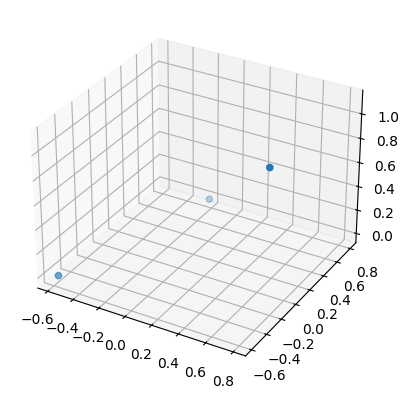

In [66]:
points = np.eye(3)

a, b, c, d = best_fit_plane(points)
print(a, b, c, d)


R = get_transforms(a, b, c, d)

new_pts = []
for pt in points:
    new_pt = []
    for i in range(3):
        new_pt.append(pt[i])
    new_pt.append(1)
    pt = np.array(new_pt).reshape(1, 4)
    
    pt = R @ pt.T
    
    new_pt = pt.T.squeeze()[:3]
    print(new_pt)

    new_pts.append(new_pt)
new_pts = np.array(new_pts)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(new_pts[:, 0], new_pts[:, 1], new_pts[:, 2])


[[-0.06722581 -0.01399464  0.04517286]
 [-0.04177393 -0.01205982  0.02832212]
 [-0.02437937 -0.01141965  0.02798457]
 [ 0.          0.          0.        ]
 [ 0.0284788  -0.00723864  0.02751097]
 [ 0.04682591 -0.01564023  0.03424332]
 [ 0.07980099 -0.01830397  0.04850171]
 [ 0.10180202 -0.03171911  0.04174095]
 [ 0.12456789 -0.04090224  0.0635624 ]
 [ 0.13585204 -0.04775249  0.09042145]]
[0.22291342 0.05781735 0.01257062]
0.06348846998597904 0.9074582014915471 0.4153177418851334 -0.001298969860315427
[[-0.06933263 -0.04410801  0.0004945 ]
 [-0.04296217 -0.02904366 -0.00313223]
 [-0.02562178 -0.02917772 -0.00158715]
 [ 0.          0.         -0.00129897]
 [ 0.02694572 -0.02915129  0.00536614]
 [ 0.04515516 -0.03952073  0.00170294]
 [ 0.07723951 -0.05491581  0.007301  ]
 [ 0.10015321 -0.05528605 -0.00628372]
 [ 0.12184264 -0.0798549  -0.00410883]
 [ 0.13166827 -0.10755225  0.00154631]]
[0.22291342 0.05781735 0.01257062]
0.0 -4.4073429515380836e-17 1.0 1.6209605299285524e-18


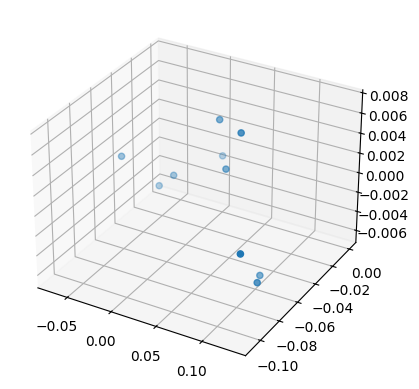

In [68]:
points = []
for i in range(len(transforms["frames"])):
    tf = transforms["frames"][i]["transform_matrix"]
    tf = np.array(tf).reshape(4, 4)
    points.append(tf[0:3, 3])

points = np.array(points)
print(points)

a, b, c, d = best_fit_plane(points)
print(a, b, c, d)

R = get_transforms(a, b, c, d)

points = []
for i in range(len(transforms["frames"])):
    tf = transforms["frames"][i]["transform_matrix"]
    tf = np.array(tf).reshape(4, 4)
    tf = R @ tf
    points.append(tf[0:3, 3])

points = np.array(points)
print(points)

a, b, c, d = best_fit_plane(points)
print(a, b, c, d)

# Plot the points

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2])


plt.show()